#Load Files From kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"waleeedosama","key":"2a11b1ee86a572c1cbc9a637b1208e3f"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d tongpython/cat-and-dog

 87% 190M/218M [00:00<00:00, 233MB/s]
100% 218M/218M [00:00<00:00, 238MB/s]


In [7]:
! unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

# Code

In [8]:
# %pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html


In [9]:
import os 
import zipfile 
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from keras import Model 
import matplotlib.pyplot as plt

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
base_dir = './'
train_dir = './training_set/training_set'
validation_dir = './test_set/test_set'

# Directory with our training cat pictures
train_cats_dir = './training_set/training_set/cats'

# Directory with our training dog pictures
train_dogs_dir = './training_set/training_set/dogs'

# Directory with our validation cat pictures
validation_cats_dir = './test_set/test_set/cats'

# Directory with our validation dog pictures
validation_dogs_dir = './test_set/test_set/dogs'

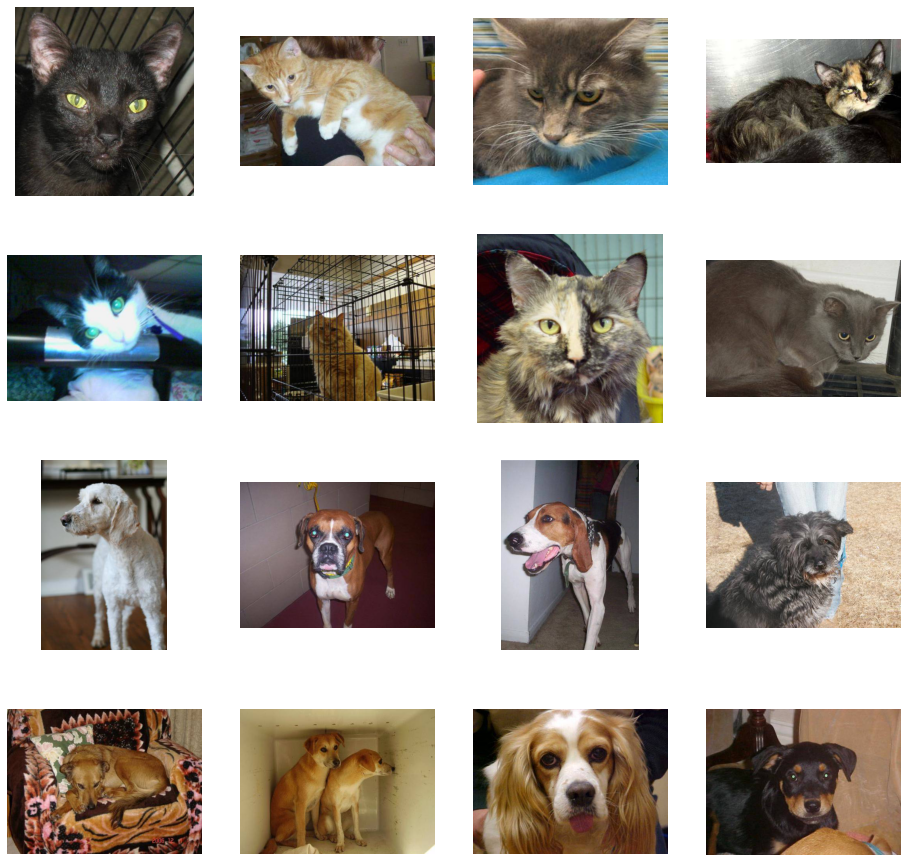

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (180, 180))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (180, 180))

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [15]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (180, 180, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
x = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180,3))(base_model.output)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
# x = layers.MaxPooling2D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(2)(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam', loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics = ['acc'])

In [18]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs = 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/15
401/401 [==============================] - 102s 218ms/step - loss: 0.1740 - acc: 0.9343 - val_loss: 0.0559 - val_acc: 0.9787
Epoch 2/15
401/401 [==============================] - 85s 211ms/step - loss: 0.1162 - acc: 0.9554 - val_loss: 0.0540 - val_acc: 0.9778
Epoch 3/15
401/401 [==============================] - 84s 210ms/step - loss: 0.1011 - acc: 0.9597 - val_loss: 0.0581 - val_acc: 0.9773
Epoch 4/15
401/401 [==============================] - 84s 209ms/step - loss: 0.0911 - acc: 0.9638 - val_loss: 0.0542 - val_acc: 0.9802
Epoch 5/15
401/401 [==============================] - 84s 210ms/step - loss: 0.0953 - acc: 0.9609 - val_loss: 0.0622 - val_acc: 0.9748
Epoch 6/15
401/401 [==============================] - 83s 208ms/step - loss: 0.0905 - acc: 0.9610 - val_loss: 0.0551 - val_acc: 0.9768
Epoch 7/15
401/401 [==============================] - 83s 208ms/step - loss: 0.0828 - acc: 0.9671 - val_loss: 0.0571 - val_acc: 0.9822
Epoch 8/15
401/401 [==============================] - 

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              